In [1]:
import os
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [3]:
device = torch.device("cuda")

In [4]:
def dataset_x(path,data_augmentaion=False):
    pics = os.listdir(path)
    pics_list=[]
    if(data_augmentaion==True):
        for pic in pics:
            img = cv.imread(path+'/'+pic)
            #img = cv.resize(img, (32, 32))
            img = np.array(img)
            img = img/255
            flip_img = np.array(cv.flip(img, 1))
            flip_img=flip_img/255
            equ_img = cv.equalizeHist(cv.cvtColor(img,cv.COLOR_BGR2GRAY))
            equ_img=np.array(cv.cvtColor(equ_img,cv.COLOR_GRAY2BGR))
            equ_img=equ_img/255
            pics_list.append(img)
            pics_list.append(flip_img)
            pics_list.append(equ_img)
    else:
        for pic in pics:
            img = cv.imread(path+'/'+pic)
            img = cv.resize(img, (32, 32))
            img = np.array(img)
            img = img/255
            pics_list.append(img)
    x = torch.Tensor(np.array(pics_list)).permute(0,3,1,2)
    return x
    

In [5]:
def dataset_y(dataset_x,type):
    size = dataset_x.shape[0]
    y = type*torch.ones([size])
    return y

In [6]:
train_empty_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/train/empty')


In [7]:
train_people_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/train/people')


In [8]:
train_train_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/train/train')


In [9]:
val_empty_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/val/empty')


In [10]:
val_people_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/val/people')


In [11]:
val_train_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/val/train')


In [12]:
test_empty_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/test/empty')


In [13]:
test_people_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/test/people')


In [14]:
test_train_x = dataset_x('/home/hatcher/test/intelligent-information-processing/Chapter7-CNN/CTH/test/train')


In [15]:
train_empty_y = dataset_y(train_empty_x,0)
train_people_y = dataset_y(train_people_x,1)
train_train_y = dataset_y(train_train_x,2)
val_empty_y = dataset_y(val_empty_x,0)
val_people_y = dataset_y(val_people_x,1)
val_train_y = dataset_y(val_train_x,2)
test_empty_y = dataset_y(test_empty_x,0)
test_people_y = dataset_y(test_people_x,1)
test_train_y = dataset_y(test_train_x,2)

In [16]:
import torch.utils.data as Data
batch_size = 48# 将训练数据的特征和标签组合
train_dataset = Data.TensorDataset(train_empty_x,train_empty_y)+Data.TensorDataset(train_people_x,train_people_y)+Data.TensorDataset(train_train_x,train_train_y)
val_dataset = Data.TensorDataset(val_empty_x,val_empty_y)+Data.TensorDataset(val_train_x,val_train_y)+Data.TensorDataset(val_people_x,val_people_y)
test_dataset = Data.TensorDataset(test_empty_x,test_empty_y)+Data.TensorDataset(test_people_x,test_people_y)+Data.TensorDataset(test_train_x,test_train_y)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
val_iter = Data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_iter = Data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True,num_workers=2)

In [30]:
class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        # 定义一个三层卷积
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128, 3)

    def forward(self, X):
        # 图片先经过三层卷积，输出维度(batch_size,C_out,H,W)
        out = self.conv(X)
        # 使用平均池化层将图片的大小变为1X1
        out = F.avg_pool2d(out, out.shape[2])
        # 将张量out从shape batch 128 x 1 x 1 x 1 变成  batch 128
        out = out.squeeze()
        # 输入到全连接层将输出的维度变为3
        out = self.fc(out)
        return out

In [45]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

In [46]:
def train(net,train_iter,val_iter,loss,num_epochs,optimizer):
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    return train_loss,val_loss,train_accuracy,val_accuracy

In [20]:
import matplotlib.pyplot as plt
import numpy as np
def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()    
    plt.show()

In [51]:
num_epochs=50
lr=0.01
loss=nn.CrossEntropyLoss()

In [52]:
net = ConvModule()
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)
for params in net.parameters():
    nn.init.normal_(params,mean=0,std=0.01)

In [53]:
train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_iter,val_iter,loss,num_epochs,optimizer)

epoch1,loss0.0103,train acc 0.765071,val acc 0.690
epoch2,loss0.0045,train acc 0.916286,val acc 0.728
epoch3,loss0.0030,train acc 0.940500,val acc 0.734
epoch4,loss0.0024,train acc 0.950643,val acc 0.751
epoch5,loss0.0021,train acc 0.957357,val acc 0.818
epoch6,loss0.0020,train acc 0.963643,val acc 0.868
epoch7,loss0.0018,train acc 0.968179,val acc 0.862
epoch8,loss0.0018,train acc 0.967143,val acc 0.789
epoch9,loss0.0014,train acc 0.975536,val acc 0.796
epoch10,loss0.0014,train acc 0.976964,val acc 0.869
epoch11,loss0.0013,train acc 0.977500,val acc 0.782
epoch12,loss0.0012,train acc 0.980571,val acc 0.859
epoch13,loss0.0011,train acc 0.982071,val acc 0.817
epoch14,loss0.0011,train acc 0.981393,val acc 0.870
epoch15,loss0.0011,train acc 0.982393,val acc 0.865
epoch16,loss0.0010,train acc 0.984786,val acc 0.818
epoch17,loss0.0009,train acc 0.985429,val acc 0.816
epoch18,loss0.0009,train acc 0.985929,val acc 0.841
epoch19,loss0.0007,train acc 0.988750,val acc 0.773
epoch20,loss0.0008,tr

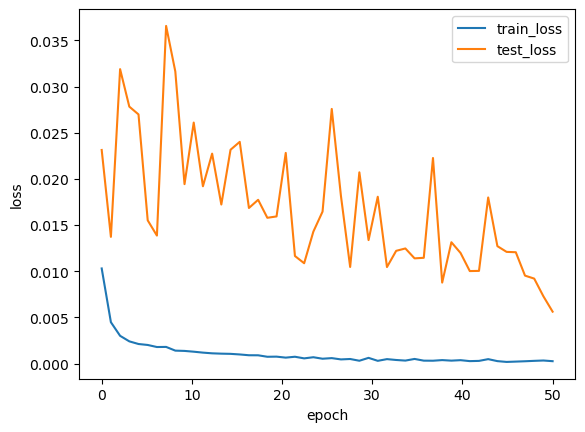

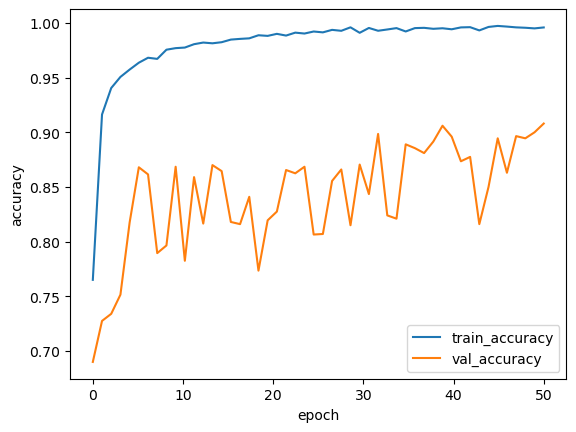

In [54]:
visualization(train_loss,val_loss,train_accuracy,val_accuracy)

In [55]:
test_acc,_ = evaluate_accuracy(test_iter,net,loss)
print("在测试集上的准确率为:%.3f"%(test_acc))

在测试集上的准确率为:0.917
